An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


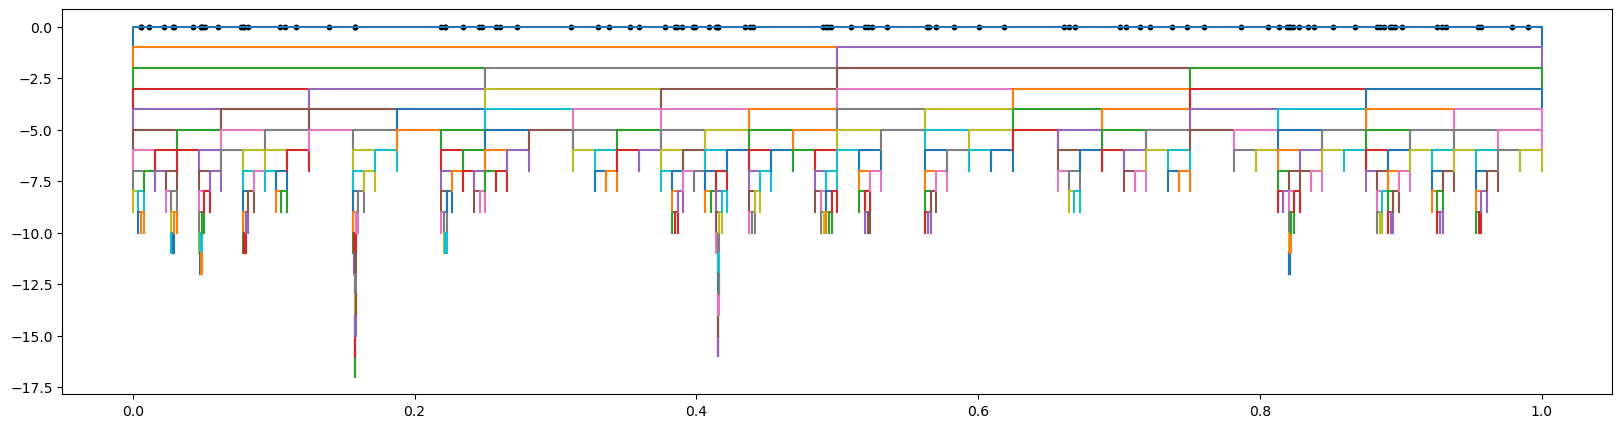

In [1]:
import sys
sys.path.append('../')

import jax
# set jax precision 64 bit
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from trees import get_1d_tree, get_data_1d, plot_1d_tree, is_far
from trees import flatten_around_point, get_features, plot_1d_tree, data_plotter
from trees import potential_from_features, potential_from_points

# Example usage
key = jax.random.PRNGKey(0)
N = 100
max_points = 1
center_x, width = 0.5, 1.0

i = np.arange(N)
x = jax.random.uniform(key, (N,), minval=center_x-width/2, maxval=center_x+width/2)
tree_1d = get_1d_tree(i, x, center_x, width, max_points=max_points, data_func=get_data_1d)

plt.figure(figsize=(20, 5))
plot_1d_tree(tree_1d, depth=0, data_plotter=None)
plt.scatter(x, np.zeros_like(x), color='black', s=10)


(-0.05, 1.05, -2.1, 0.1)

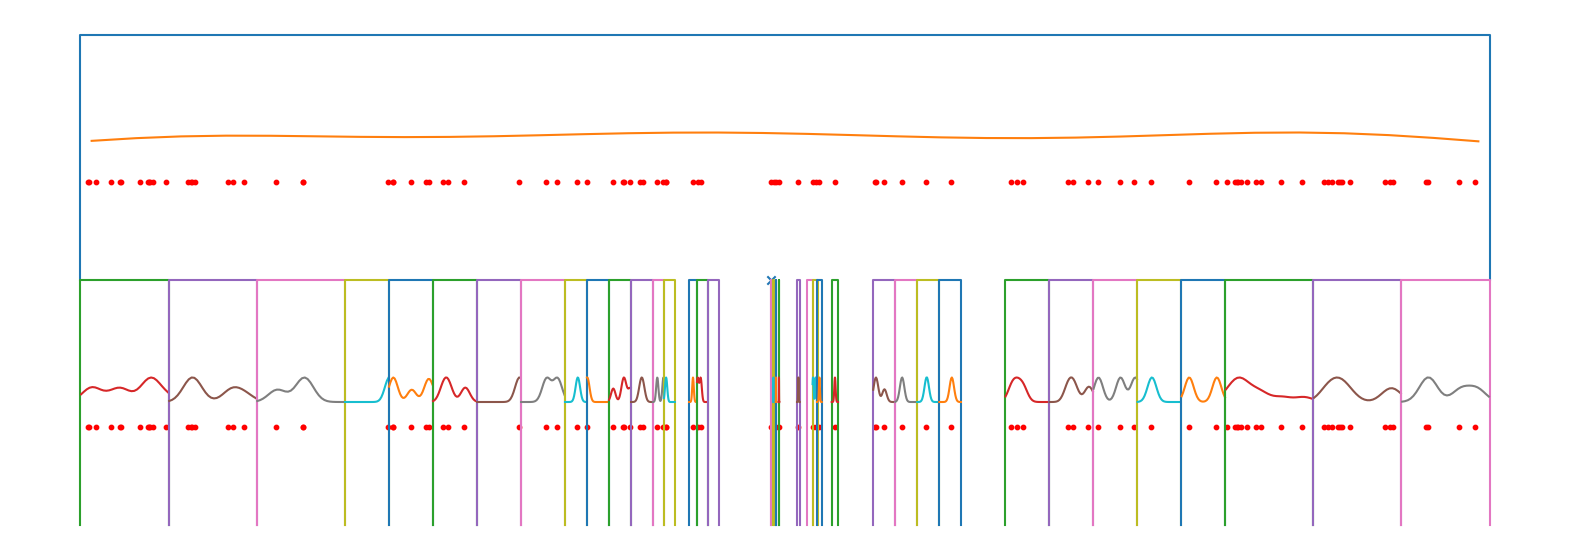

In [2]:

ratio = 0.2
x0 = x[10]#0.2
new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
new_leavy_tree_1d = {"children": new_leaves_1d, "data": tree_1d["data"]}
x0_features = get_features(new_leaves_1d)

plt.figure(figsize=(20, 7))
plot_1d_tree(new_leavy_tree_1d, data_plotter=data_plotter)
plt.scatter([x0], [-1], marker='x')
plt.axis("off")

In [3]:

val = potential_from_points(x0, x)
fmm_val = potential_from_features(x0, x0_features)
print(f"True value: {val}, FMM value: {fmm_val}, Rel. Error: {jnp.abs(val - fmm_val)/jnp.abs(val)}")

training_data = []
data_error = []
for x0 in x:
    new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
    new_leaves_1d = [leaf for leaf in new_leaves_1d if is_far(leaf, x0, ratio)]
    x0_features = get_features(new_leaves_1d)
    x0_features = x0_features.at[:,-2].set(x0_features[:,-2] - x0)
    
    val = potential_from_points(x0, x) / len(x)
    fmm_val = potential_from_features(0., x0_features) / len(x)
    error = jnp.abs(val - fmm_val)/jnp.abs(val)
    print(f"True value: {val:.2f}, FMM value: {fmm_val:.2f}, Rel. Error: {error:.2e} ===========", end='\r')
    data_error.append(error)
    training_data.append((x0_features, val))   

True value: 344.72433244199357, FMM value: 344.75149552408027, Rel. Error: 7.879653256351555e-05


In [4]:
from flax import linen as nn
import jax
import jax.numpy as jnp

class MultiHeadSelfAttention(nn.Module):
    embed_dim: int
    num_heads: int

    def setup(self):
        assert self.embed_dim % self.num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.head_dim = self.embed_dim // self.num_heads
        self.qkv_proj = nn.Dense(self.embed_dim * 3)  # For Query, Key, Value
        self.out_proj = nn.Dense(self.embed_dim)

    def __call__(self, x):
        batch_size, seq_len, embed_dim = x.shape 
        assert embed_dim == self.embed_dim, "Input embedding dimension does not match module embedding dimension."
        
        qkv = self.qkv_proj(x)  # Shape: (batch_size, seq_len, embed_dim * 3)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        q, k, v = jnp.split(qkv, 3, axis=2)  # Each: (batch_size, seq_len, num_heads, head_dim)
        q, k, v = q.squeeze(2), k.squeeze(2), v.squeeze(2)

        attn_weights = jax.nn.softmax(jnp.einsum("bqhd,bkhd->bhqk", q, k) / jnp.sqrt(self.head_dim), axis=-1)
        attn_output = jnp.einsum("bhqk,bkhd->bqhd", attn_weights, v)
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        return self.out_proj(attn_output)

class TransformerEncoderLayer(nn.Module):
    embed_dim: int
    num_heads: int
    ff_hidden_dim: int
    dropout_rate: float

    def setup(self):
        self.attention = MultiHeadSelfAttention(self.embed_dim, self.num_heads)
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.feed_forward = nn.Sequential([
            nn.Dense(self.ff_hidden_dim),
            nn.gelu,
            nn.Dense(self.embed_dim),
        ])
        self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, train: bool = True):
        # Multi-head self-attention
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)#self.dropout(attn_out, deterministic=not train))
        # Feed-forward network
        ff_out = self.feed_forward(x)
        x = self.norm2(x + ff_out)# + self.dropout(ff_out, deterministic=not train))
        return x

class Transformer(nn.Module):
    embed_dim: int
    num_heads: int
    ff_hidden_dim: int
    num_layers: int
    dropout_rate: float

    def setup(self):
        self.layers = [
            TransformerEncoderLayer(self.embed_dim, self.num_heads, self.ff_hidden_dim, self.dropout_rate)
            for _ in range(self.num_layers)
        ]
        self.final_norm = nn.LayerNorm()
        self.output_layer = nn.Dense(1)  # Produces a single scalar output

    def __call__(self, x, train: bool = True):
        # Apply each Transformer Encoder layer
        for layer in self.layers:
            x = layer(x, train=train)
        x = self.final_norm(x)
        # Global average pooling to make the output independent of sequence length
        x = jnp.mean(x, axis=1)
        # Final projection to a single output
        x = self.output_layer(x)
        return x

# Example usage
num_heads = 1
ff_hidden_dim = 128
num_layers = 3
dropout_rate = 0.1

x0, y0 = training_data[0]
x0 = x0[None, :]
key = jax.random.PRNGKey(0)
batch_size, seq_len, embed_dim = x0.shape
model = Transformer(embed_dim, num_heads, ff_hidden_dim, num_layers, dropout_rate)
params = model.init(key, x0)


loss = jax.jit(lambda params, x, y: jnp.mean(jnp.abs((model.apply(params, x) - y))**2/y**2))
grad_loss = jax.jit(jax.grad(loss, 0))

def update_params(params, grad_params, lr=0.01):
    return jax.tree.map(lambda p, g: p - lr * g, params, grad_params)

avg_losses = []
max_losses = []
min_losses = []
for i in range(1000):
    epoch_losses = []
    for (x, y) in training_data:
        x = x[None, :]
        y = y#jnp.log(y)
        loss_params = loss(params, x, y)
        grad_loss_params = grad_loss(params, x, y)
        params = update_params(params, grad_loss_params)
        epoch_losses.append(loss_params)
        print(f"Loss: {loss_params:3f}", end="\r")  # Expected: (batch_size, 1)
    avg_losses.append(jnp.mean(epoch_losses))
    max_losses.append(jnp.max(epoch_losses))
    min_losses.append(jnp.min(epoch_losses))


TypeError: mean requires ndarray or scalar arguments, got <class 'list'> at position 0.

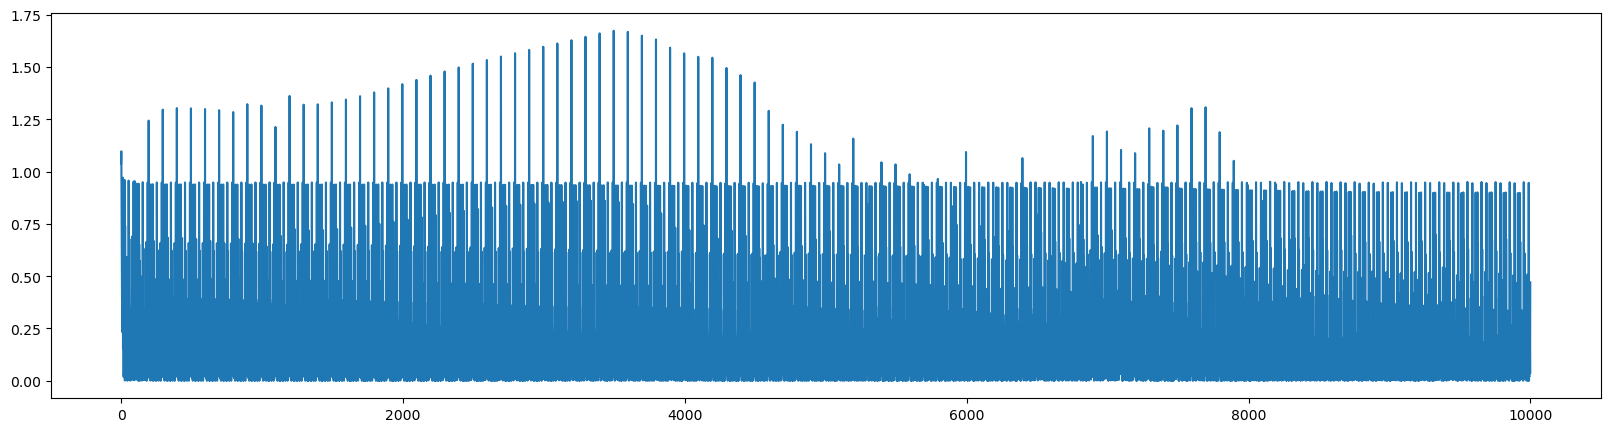

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(avg_losses)
plt.plot(max_losses)
plt.plot(min_losses)

In [6]:
from flax import linen as nn
import jax
import jax.numpy as jnp
if False:
    class MultiHeadSelfAttention(nn.Module):
        embed_dim: int
        num_heads: int

        def setup(self):
            assert self.embed_dim % self.num_heads == 0, "Embedding dimension must be divisible by the number of heads."
            self.head_dim = self.embed_dim // self.num_heads
            self.qkv_proj = nn.Dense(self.embed_dim * 3)  # For Query, Key, Value
            self.out_proj = nn.Dense(self.embed_dim)

        def __call__(self, x):
            batch_size, seq_len, embed_dim = x.shape 
            assert embed_dim == self.embed_dim, "Input embedding dimension does not match module embedding dimension."
            
            qkv = self.qkv_proj(x)  # Shape: (batch_size, seq_len, embed_dim * 3)
            qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
            q, k, v = jnp.split(qkv, 3, axis=2)  # Each: (batch_size, seq_len, num_heads, head_dim)
            q, k, v = q.squeeze(2), k.squeeze(2), v.squeeze(2)

            attn_weights = jax.nn.softmax(jnp.einsum("bqhd,bkhd->bhqk", q, k) / jnp.sqrt(self.head_dim), axis=-1)
            attn_output = jnp.einsum("bhqk,bkhd->bqhd", attn_weights, v)
            attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
            return self.out_proj(attn_output)

    class TransformerEncoderLayer(nn.Module):
        embed_dim: int
        num_heads: int
        ff_hidden_dim: int
        dropout_rate: float

        def setup(self):
            self.attention = MultiHeadSelfAttention(self.embed_dim, self.num_heads)
            self.norm1 = nn.LayerNorm()
            self.norm2 = nn.LayerNorm()
            self.feed_forward = nn.Sequential([
                nn.Dense(self.ff_hidden_dim),
                nn.gelu,
                nn.Dense(self.embed_dim),
            ])
            self.dropout = nn.Dropout(rate=self.dropout_rate)

        def __call__(self, x, train: bool = True):
            # Multi-head self-attention
            attn_out = self.attention(x)
            x = self.norm1(x)# + self.dropout(attn_out, deterministic=not train))
            # Feed-forward network
            ff_out = self.feed_forward(x)
            x = self.norm2(x)# + self.dropout(ff_out, deterministic=not train))
            return x

    class Transformer(nn.Module):
        embed_dim: int
        num_heads: int
        ff_hidden_dim: int
        num_layers: int
        dropout_rate: float

        def setup(self):
            self.layers = [
                TransformerEncoderLayer(self.embed_dim, self.num_heads, self.ff_hidden_dim, self.dropout_rate)
                for _ in range(self.num_layers)
            ]
            self.final_norm = nn.LayerNorm()
            self.output_layer = nn.Dense(1)  # Produces a single scalar output

        def __call__(self, x, train: bool = True):
            # Apply each Transformer Encoder layer
            for layer in self.layers:
                x = layer(x, train=train)
            x = self.final_norm(x)
            # Global average pooling to make the output independent of sequence length
            x = jnp.mean(x, axis=1)
            # Final projection to a single output
            x = self.output_layer(x)
            return x

    # Example usage
    num_heads = 10
    ff_hidden_dim = 128
    num_layers = 4
    dropout_rate = 0.1

    x0, y0 = training_data[0]
    key = jax.random.PRNGKey(0)
    _, embed_dim = x0.shape
    batch_size = 1
    model = Transformer(embed_dim, num_heads, ff_hidden_dim, num_layers, dropout_rate)
    params = model.init(key, x0[None, :])


    loss = jax.jit(lambda params, x, y: jnp.mean(jnp.abs((model.apply(params, x) - y))**2))
    loss_v = lambda params, xv, yv: jnp.mean(jnp.array([loss(params, x[None,:], y) for x, y in zip(xv, yv)]))
    grad_loss = jax.jit(jax.grad(loss_v, 0))

    def update_params(params, grad_params, lr=0.001):
        return jax.tree.map(lambda p, g: p - lr * g, params, grad_params)

    #for (x, y) in training_data:
    for i in range(100):
        key, subkey = jax.random.split(key)
        subsample = jax.random.choice(subkey, np.arange(len(training_data)), (16,), replace=False)
        xv, yv = zip(*[training_data[i] for i in subsample])
        
        # Initialize and apply the Transformer
        loss_params = loss_v(params, xv, yv)
        grad_loss_params = grad_loss(params, xv, yv)
        params = update_params(params, grad_loss_params)

        print(f"Loss: {loss_params}")  # Expected: (batch_size, 1)
